In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import numpy as np
import sesd
from statsmodels.tsa.seasonal import STL

In [2]:
df = pd.read_csv('bmw.csv')
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


In [12]:
#This function use for scatterplot which highlight the anomalies
def scatterplot_with_color_coding(x_data, y_data, color_code_column, x_label, y_label, title):
    """
    Arguments:
        x_data: Series. Desired x-axis for scatterplot.
        y_data: Series. Desired y-axis for scatterplot.
        color_code_column: Series. Column to color-code data points in scatterplot by.
        x_label: String. Label for x-axis.
        y_label: String. Label for y-axis.
        title: String. Title of plot
    Outputs:
        Scatterplot in console.
    """
    fig, ax = plt.subplots()
    ax.scatter(x_data, y_data, c=color_code_column)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    fig.autofmt_xdate()

# Isolation forest

In [3]:
def isolation_forest_anomaly_detection(df, 
                                       column_name, 
                                       outliers_fraction):
    """
    In this definition, time series anomalies are detected using an Isolation Forest algorithm.
    Arguments:
        df: Pandas dataframe
        column_name: string. Name of the column that we want to detect anomalies in
        outliers_fraction: float. Percentage of outliers allowed in the sequence.
    Outputs:
        df: Pandas dataframe with column for detected Isolation Forest anomalies (True/False)
    """
    #Scale the column that we want to flag for anomalies
    min_max_scaler = preprocessing.StandardScaler()
    np_scaled = min_max_scaler.fit_transform(df[[column_name]])
    scaled_time_series = pd.DataFrame(np_scaled)
    # train isolation forest 
    model =  IsolationForest(contamination = outliers_fraction)
    model.fit(scaled_time_series)
    #Generate column for Isolation Forest-detected anomalies
    isolation_forest_anomaly_column = column_name+'_Isolation_Forest_Anomaly'
    df[isolation_forest_anomaly_column] = model.predict(scaled_time_series)
    df[isolation_forest_anomaly_column] = df[isolation_forest_anomaly_column].map( {1: False, -1: True} )
    return df

In [5]:
df_with_oil = df[(df['fuelType'] =='Diesel') | (df['fuelType'] =='Petrol')].sort_values(by=['year'])
df_with_hybrid = df[(df['fuelType'] =='Hybrid')].sort_values(by=['year'])
df_with_electric = df[(df['fuelType'] =='Electric')].sort_values(by=['year'])
df_with_other = df[(df['fuelType'] =='Other')].sort_values(by=['year'])
((df_with_oil.shape),(df_with_hybrid.shape),(df_with_electric.shape),(df_with_other.shape))

((10444, 9), (298, 9), (3, 9), (36, 9))

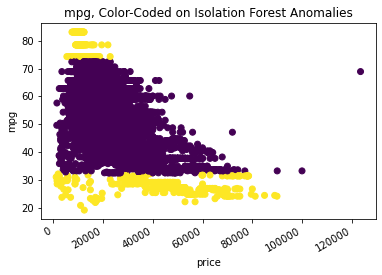

In [7]:
mpg_iso_forest_df=isolation_forest_anomaly_detection(df=df_with_oil, 
                                                         column_name='mpg', 
                                                         outliers_fraction=.06)
#Re-plot time series with color coding for anomaly column
scatterplot_with_color_coding(df_with_oil['price'],
                                  mpg_iso_forest_df['mpg'], 
                                  mpg_iso_forest_df['mpg_Isolation_Forest_Anomaly'],
                                  'price', 
                                  'mpg', 
                                  'mpg, Color-Coded on Isolation Forest Anomalies') 

# Seasonal-Extreme Studentized Deviate (S-ESD)

In [8]:
def sesd_anomaly_detection(dataframe, 
                           column_name, 
                           desired_frequency, 
                           max_anomalies,
                           alpha_level):
    """
    In this definition, time series anomalies are detected using the S-ESD algorithm.
    Arguments:
        dataframe: Pandas dataframe
        column_name: string. Name of the column that we want to detect anomalies in
        desired_frequency: Integer. Time frequency of the series. If we want to detect 
        a yearly trend, we'd set the value equal to 365.
        max_anomalies: Integer. Max number of anomalies to look for in the time series
        sequence.
        alpha_level: The significance level.
    Outputs:
        df: Pandas dataframe with column for detected S-ESD anomalies (True/False)
    """
    series=np.array(dataframe[column_name])
    #Implement SESD algorithm on the time series
    outliers_indices = sesd.seasonal_esd(series, 
                                         hybrid=False, 
                                         max_anomalies=max_anomalies, 
                                         alpha=alpha_level)
    #Create a column for SESD anomalies
    sesd_anomaly_column=column_name+'_SESD_Anomaly'
    #Create a detected anomaly column, and mark as False if normal, and True if anomalous
    dataframe[sesd_anomaly_column]=False
    dataframe.loc[dataframe.index.isin(outliers_indices), sesd_anomaly_column]=True
    return dataframe

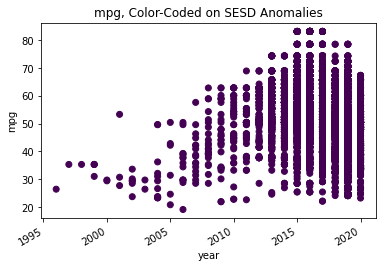

In [9]:
mpg_sesd_df=sesd_anomaly_detection(dataframe=df_with_oil, 
                           column_name='mpg', 
                           desired_frequency=365, 
                           max_anomalies=20,
                           alpha_level=10)
#Re-plot time series with color coding for anomaly column
scatterplot_with_color_coding(df_with_oil['year'],
                                  df_with_oil['mpg'], 
                                  df_with_oil['mpg_SESD_Anomaly'],
                                  'year', 
                                  'mpg', 
                                  'mpg, Color-Coded on SESD Anomalies') 

# Low pass filter

In [10]:
def low_pass_filter_anomaly_detection(df, 
                                      column_name, 
                                      number_of_stdevs_away_from_mean):
    """
    Implement a low-pass filter to detect anomalies in a time series, and save the filter outputs 
    (True/False) to a new column in the dataframe.
    Arguments:
        df: Pandas dataframe
        column_name: string. Name of the column that we want to detect anomalies in
        number_of_stdevs_away_from_mean: float. Number of standard deviations away from
        the mean that we want to flag anomalies at. For example, if 
        number_of_stdevs_away_from_mean=2,
        then all data points more than 2 standard deviations away from the mean are flagged as 
        anomalies.
    Outputs:
        df: Pandas dataframe. Dataframe containing column for low pass filter anomalies 
        (True/False)
    """
    #60-day rolling average
    df[column_name+'_Rolling_Average']=df[column_name].rolling(window=60, center=True).mean()
    #60-day standard deviation 
    df[column_name+'_Rolling_StDev']=df[column_name].rolling(window=60, center=True).std()
    #Detect anomalies by determining how far away from the mean (in terms of standard deviation)
    #each data point is
    df[column_name+'_Low_Pass_Filter_Anomaly']=(abs(df[column_name]-df[
                                column_name+'_Rolling_Average'])>(
                                number_of_stdevs_away_from_mean*df[
                                column_name+'_Rolling_StDev']))
    return df

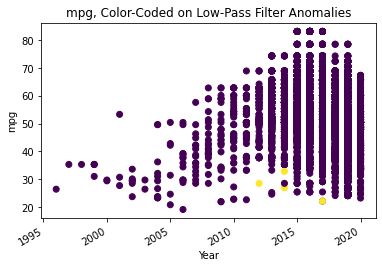

In [11]:
mpg_low_pass_df=low_pass_filter_anomaly_detection(df=df_with_oil, 
                                      column_name='mpg', 
                                      number_of_stdevs_away_from_mean=3)
#Re-plot time series with color coding for anomaly column
scatterplot_with_color_coding(df_with_oil['year'],
                                  df_with_oil['mpg'], 
                                  df_with_oil['mpg_Low_Pass_Filter_Anomaly'],
                                  'Year', 
                                  'mpg', 
                                  'mpg, Color-Coded on Low-Pass Filter Anomalies') 